In [16]:
import os 
import cv2
import tensorflow as tf 
import numpy as np 
from typing import List
import matplotlib.pyplot as plt
import imageio

In [17]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable


In [29]:
def load_video(path:str)->List[float]:
  cap=cv2.VideoCapture(path)
  frames=[]
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame=cap.read()
    frame=tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()

  mean=tf.math.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames-mean),tf.float32)/std 

In [19]:
vocab=[x for x in "qwertyuiopasdfghjklzxcvbnm'?123456789"]

In [73]:
char_to_num= tf.keras.layers.StringLookup(vocabulary= vocab,oov_token="")
num_to_char=tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"size: {char_to_num.vocabulary_size()}"
)

The vocabulary is: ['', 'q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p', 'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm', "'", '?', '1', '2', '3', '4', '5', '6', '7', '8', '9']size: 38


In [41]:
def load_alignments(path:str) -> List[str]:
  with open(path, 'r') as f:
    lines= f.readlines()
  tokens=[]
  for line in lines:
    line=line.split()
    if line[2] != 'sil':
      tokens=[*tokens, ' ',line[2]]
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [116]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','data','s1',f'{file_name}.mpg')
    print(video_path)
    alignment_path = os.path.join('data','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [63]:
test_path='./data/data/s1/bbaf2n.mpg'

<tf.Tensor: shape=(), dtype=string, numpy=b'./data/data/s1/bbaf2n.mpg'>

In [70]:
frames, alignments=load_data(tf.convert_to_tensor(test_path))

data\data\s1\bbaf2n.mpg


In [67]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991665 ],
         [1.4991665 ],
         [1.4616873 ],
         ...,
         [0.41227078],
         [0.41227078],
         [0.41227078]],

        [[1.4991665 ],
         [1.4991665 ],
         [1.4616873 ],
         ...,
         [0.41227078],
         [0.41227078],
         [0.41227078]],

        [[1.4616873 ],
         [1.4616873 ],
         [1.4991665 ],
         ...,
         [0.33731246],
         [0.33731246],
         [0.33731246]],

        ...,

        [[1.0494165 ],
         [1.0494165 ],
         [1.0119374 ],
         ...,
         [0.11243749],
         [0.11243749],
         [0.07495832]],

        [[1.0494165 ],
         [1.0494165 ],
         [1.0119374 ],
         ...,
         [0.11243749],
         [0.07495832],
         [0.07495832]],

        [[1.0494165 ],
         [1.0494165 ],
         [1.0119374 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

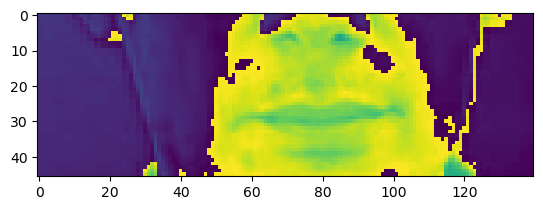

In [68]:
plt.imshow(frames[1])

In [96]:
def mappable_function(path:str)->List[str]:
    result= tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [143]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [82]:
[bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]

['b',
 'i',
 'n',
 '',
 'b',
 'l',
 'u',
 'e',
 '',
 'a',
 't',
 '',
 'f',
 '',
 't',
 'w',
 'o',
 '',
 'n',
 'o',
 'w']

In [123]:
data= tf.data.Dataset.list_files('./data/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)

data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [130]:

len(test)
frames, alignments = data.as_numpy_iterator().next()
len(frames)
sample = data.as_numpy_iterator()
val = sample.next(); val[0]
imageio.mimsave('./animation.gif', val[0][0], fps=10)


data\data\s1\lgamzp.mpg
data\data\s1\bgah1s.mpg
data\data\s1\srao1a.mpg
data\data\s1\bgit6p.mpg


Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

data\data\s1\bbifzp.mpg
data\data\s1\lwilzp.mpg


Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.906294822692871]. Convert image to uint8 prior to saving to suppress this warning.


data\data\s1\lrar1s.mpg


In [131]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'bingreenintsixplease'>

In [132]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [133]:
data.as_numpy_iterator().next()[0][0].shape


data\data\s1\lgil7a.mpg
data\data\s1\bgah2p.mpg
data\data\s1\bwbg9s.mpg


(75, 46, 140, 1)

In [135]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [136]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [137]:
yhat = model.predict(val[0])


1/1 [==============================] - 2s 2s/step


In [138]:
yhat = model.predict(val[0])


1/1 [==============================] - 1s 1s/step


In [152]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [157]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [159]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [175]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),loss=CTCLoss)

In [176]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)


In [162]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100
data\data\s1\bwwu3a.mpg
data\data\s1\sbig5s.mpg
data\data\s1\sgbj2p.mpg
data\data\s1\brif6p.mpg
data\data\s1\sbwu4n.mpg
data\data\s1\briz6n.mpg
data\data\s1\brbm6n.mpg
data\data\s1\bwaazn.mpg
  1/450 [..............................] - ETA: 3:56:57 - loss: 226.6159data\data\s1\swwc7a.mpg
data\data\s1\pgbk7s.mpg
  2/450 [..............................] - ETA: 3:17:32 - loss: 199.7186data\data\s1\prwq4p.mpg
data\data\s1\pgay2p.mpg
  3/450 [..............................] - ETA: 3:15:45 - loss: 181.6943data\data\s1\sgiczp.mpg
data\data\s1\sbwu7a.mpg
  4/450 [..............................] - ETA: 3:17:01 - loss: 167.8672data\data\s1\bgbu4p.mpg
data\data\s1\bbiz2p.mpg
  5/450 [..............................] - ETA: 3:17:56 - loss: 159.9343data\data\s1\pbwc9s.mpg
data\data\s1\lgbs8p.mpg
  6/450 [..............................] - ETA: 3:19:28 - loss: 154.0331data\data\s1\pwwy3s.mpg
data\data\s1\srau5a.mpg
  7/450 [..............................] - ETA: 3:19:10 - loss: 148.5643data

KeyboardInterrupt: 

In [165]:
!pip install gdown
import gdown


Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [166]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: C:\Users\Ivan\Documents\vjezbanje\python\lip_reading\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:26<00:00, 3.60MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [177]:
model.load_weights('models\checkpoint')


ValueError: Received incompatible tensor with shape (41,) when attempting to restore variable with shape (39,) and name layer_with_weights-5/bias/.ATTRIBUTES/VARIABLE_VALUE.